## Import Libraries and Modules

In [53]:
import scipy.io as scio
import numpy as np
import numpy.random as rng

from crossValidateModel import crossValidateModel
from linearSVM import linearSVM
from compiler.ast import flatten
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)
from IPython.display import display
import sklearn.svm as svm


## Load data
Load dataset from desk. These are:
    - X matrix (size trials x neurons) that contains neural responses at different trials.
    - Y choice of high rate (modeled as 1) and low rate (modeled as 0)


In [2]:
dirName = '/Users/gamalamin/git_local_repository/Farzaneh/XY.mat';
#dirName = '/home/farznaj/Shares/Churchland/data/fni17/imaging/151022/XY_fni17_151022 XY_lassoSVM.mat';
XY = scio.loadmat(dirName, variable_names=['X', 'Y']);
X = XY.pop('X').astype('float')
Y = np.squeeze(XY.pop('Y')).astype('int')
numTrials, numNeurons = X.shape

print ' The data has %d neurons recorded at %d trials' %(numTrials, numNeurons)


 The data has 274 neurons recorded at 446 trials


## Features normalization and scaling
    To removed effects related to scaling and bias of each neuron, we need to zscore data (i.e., make data mean 0 and variance 1 for each neuron) 

In [3]:
mskNan = (np.sum(np.isnan(X), axis = 1) + np.isnan(Y))==0
X = X[mskNan, :];
Y = Y[mskNan];
meanX = np.mean(X, axis = 0);
stdX = np.std(X, axis = 0);
X = (X-meanX)/stdX;

## Divide data to high and low rates
    Divide data to high rate trials and low rate trials

In [4]:
Y_HR = Y[Y==1];
X_HR = X[Y==1,:];
Y_LR = Y[Y==0];
X_LR = X[Y==0,:];
print ' %d trials are high rate and %d trials are low rate' %(len(Y_HR), len(Y_LR))

 137 trials are high rate and 137 trials are low rate


## Handle inbalance in the number of trials
    - Still need to think about that.

## Identify the best regularization parameter:
    Perform 10-fold cross validation to obtain the best regularization parameter

running l1 svm classification
try the following regularization values: %
[  3.64963504e-08   1.15411593e-07   3.64963504e-07   1.15411593e-06
   3.64963504e-06   1.15411593e-05   3.64963504e-05   1.15411593e-04
   3.64963504e-04   1.15411593e-03   3.64963504e-03   1.15411593e-02
   3.64963504e-02   1.15411593e-01   3.64963504e-01   1.15411593e+00
   3.64963504e+00   1.15411593e+01   3.64963504e+01   1.15411593e+02]


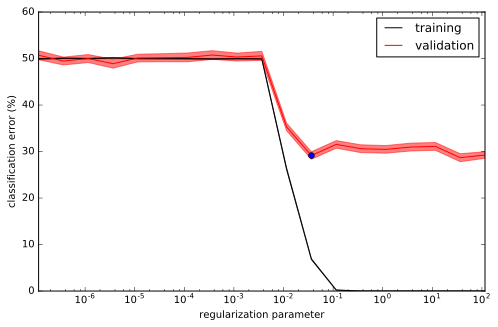

In [5]:
regType = 'l1'
kfold = 10;
numSamples = 100;
if regType == 'l1':
    print 'running l1 svm classification\r' 
    cvect = 10**(np.arange(-5, 5,0.5))/numTrials;
elif regType == 'l2':
    print 'running l2 svm classification\r' 
    cvect = 10**(np.arange(-5, 5,0.5));

print 'try the following regularization values: %\n', cvect

perClassErrorTrain = np.ones((numSamples, len(cvect)))+np.nan;
perClassErrorTest = np.ones((numSamples, len(cvect)))+np.nan;
for s in range(numSamples):
    for i in range(len(cvect)):
        if regType == 'l1':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cvect[i])
        elif regType == 'l2':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cvect[i])

        perClassErrorTrain[s, i] = summary.perClassErrorTrain;
        perClassErrorTest[s, i] = summary.perClassErrorTest;

meanPerClassErrorTrain = np.mean(perClassErrorTrain, axis = 0);
semPerClassErrorTrain = np.std(perClassErrorTrain, axis = 0)/np.sqrt(numSamples);

meanPerClassErrorTest = np.mean(perClassErrorTest, axis = 0);
semPerClassErrorTest = np.std(perClassErrorTest, axis = 0)/np.sqrt(numSamples);
ix = np.argmin(meanPerClassErrorTest);
cbest = cvect[meanPerClassErrorTest <= (meanPerClassErrorTest[ix]+semPerClassErrorTest[ix])];
cbest = cbest[0]; # best regularization term based on minError+SE criteria

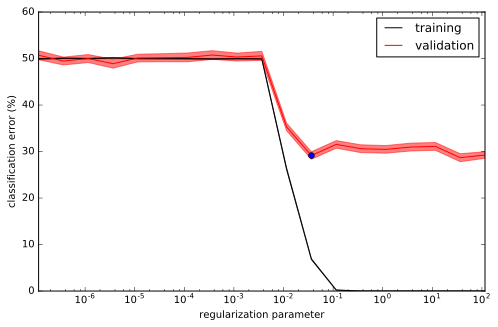

In [38]:
##%%%%%% plot coss-validation results
plt.figure('cross validation')

plt.fill_between(cvect, meanPerClassErrorTrain-semPerClassErrorTrain, meanPerClassErrorTrain+ semPerClassErrorTrain, alpha=0.5, edgecolor='k', facecolor='k')
plt.fill_between(cvect, meanPerClassErrorTest-semPerClassErrorTest, meanPerClassErrorTest+ semPerClassErrorTest, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(cvect, meanPerClassErrorTrain, 'k', label = 'training')
plt.plot(cvect, meanPerClassErrorTest, 'r', label = 'validation')
plt.plot(cvect[cvect==cbest], meanPerClassErrorTest[cvect==cbest], 'bo')
plt.xlim([cvect[1], cvect[-1]])
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.ylabel('classification error (%)')
plt.legend()

## Train the best SVM model

6.93430656934


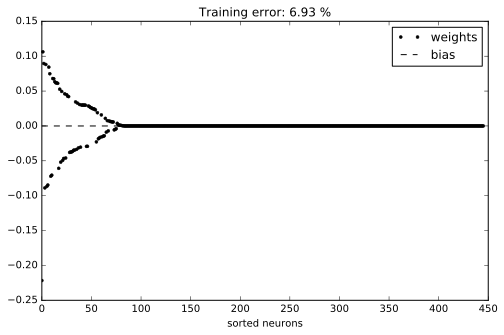

In [6]:
if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)

linear_svm.fit(X, Y)
    
w = np.squeeze(linear_svm.coef_);
b = linear_svm.intercept_;

plt.figure()
plt.plot(w[np.argsort(abs(w))[::-1]], 'k.', label = 'weights')
plt.plot(np.ones(len(w))*b, 'k--', label = 'bias')
plt.xlabel('sorted neurons')
plt.legend()
plt.title(('Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)))
print abs(((np.dot(X,w)+b)>0).astype('float')-Y.astype('float')).sum()/len(Y)*100 # this is the prediction formula


## Null distribution using shuffles


In [18]:
numShuffles = 1000
summary_data = [];
summary_shfl = [];
perClassErrorTrain_data = [];
perClassErrorTest_data = []
perClassErrorTrain_shfl = [];
perClassErrorTest_shfl = [];
w_data = []
b_data = []
w_shfl = []
b_shfl = []
permIxsList = [];
for i in range(numShuffles):
    permIxs = rng.permutation(numTrials);
    permIxsList.append(permIxs);
    if regType == 'l1':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
    elif regType == 'l2':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))
        
    perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
    perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
    w_data.append(np.squeeze(summary_data[i].model.coef_));
    b_data.append(summary_data[i].model.intercept_);
        
    perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
    perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
    w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
    b_shfl.append(summary_shfl[i].model.intercept_);



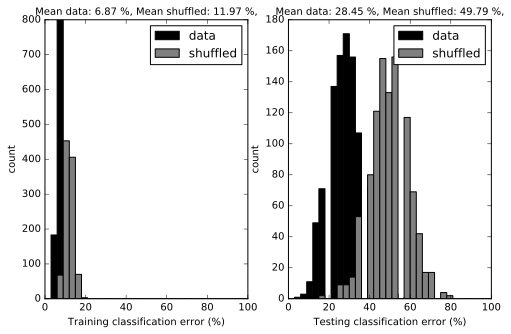

In [51]:
binEvery = 3; # bin width
plt.figure()
plt.subplot(1,2,1)
plt.hist(perClassErrorTrain_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTrain_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.xlabel('Training classification error (%)')
plt.ylabel('count')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%,' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl)), fontsize = 10)
plt.legend()

plt.subplot(1,2,2)
plt.hist(perClassErrorTest_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTest_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.legend()
plt.xlabel('Testing classification error (%)')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%,' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl)), fontsize = 10)
plt.ylabel('count')

In [52]:
len(w_data)

1000

Run lasso SVM: